# Cooperative Resonance in Light Scattering from 2D atoms
### Contributors: Reet Mhaske, JVS Shreya
##### Guides: Prof, Efi Shahmoon;  Roni Maimon, Yakov Solomons 
Reference paper: https://link.aps.org/doi/10.1103/PhysRevLett.118.113601
 
 
This file contains code to introduce random disorder in the position of the atoms 

In [1]:
import numpy.matlib
import numpy as np
import cmath
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time


Declaring global constants

In [2]:
j=complex(0,1)           # iota , sqrt of -1

c_light=3*10**8          #speed of light

epsilon=8.85*10**-12     # SI units, permitivitty of free space

e_x = np.array([1,0.,0.]) # the vector for x polarized field


Defining the Dyadic Green's Function (eq S3) $\newline$ 
$$G_{ml}(k,\textbf{r}_1,\textbf{r}_2)=\frac{e^{ikr}}{4\pi r}\left[\left(1+\frac{ikr-1}{k^2r^2}\right)\delta_{ml}+\left(-1+\frac{3-3ikr}{k^2r^2}\right)\frac{r^mr^l}{r^2}\right]$$ $\newline$
where $\textbf{r}=\textbf{r}_1-\textbf{r}_2$, $r=\left|{\textbf{r}}\right|$ , $r^j=e_j.\textbf{r}$ $ (j^{th}$ component of $r$)  and $i=\sqrt{-1}$ $\newline$


In [4]:
def Greens(m,l,k,r_1,r_2):    
    '''Calculates the greens function G_{ml}(r_1,r_2) using eq S3
    takes as input:
    the indices m and l;
    the position vectors of the two points r1 and r2 (which should be an array of length 3)
    the wavenumber k of the incident light ray
    returns: a complex number 
    Note: Never cast complex variables to standard int or float data types, it will discard the imaginary part '''
    
    if ((r_1[0]==r_2[0])and(r_1[1]==r_2[1])and(r_1[2]==r_2[2])):    #skip the same atom (as the r1-r2 is null vector)
            return 0 # returns 0 if r1 and r2 are equal
    else:
            r_vect=r_1-r_2 
            r=np.sqrt(np.sum(np.square(r_vect)))
        
    # To implement the kronecker_delta(m,l), check if m==l      
    if m==l: 
        t1=(1+ (j*k*r-1)/((k*r)**2))      
    else: 
        t1=0
        
     # compute G termwise   
    t2=(-1 + (3-3*k*r*j)/(k*r)**2)*r_vect[m]*r_vect[l]/r**2
    
    t3=(np.cos(k*r)+j*np.sin(k*r))*(t1+t2)/(4*np.pi*r)  #eq S3
    
    
    return t3

### The gaussian_ray class
We define the gaussian ray class whose instance will be the ray that will serve as incident light ray.
It has attributes of beam waist, wavelength, polarization vector, detuning $\delta = \omega-\omega_{a}$  , $\frac{\delta}{\gamma}$ , $\gamma_{nr}$ 

The gaussian_ray object as a function light_function(), which calculates the electric field of the gaussian beam at a given point, using the attributes if the gaussian_ray object

light_function() uses the Gaussian beam equation:  (eq S55)

$$\textbf{E}_0\left(x',y',z'\right) = E_0\textbf{e}_L\frac{w_0}{w(z')}e^{ikz'}e^{-i\phi(z')}e^{-\frac{x'^2+y'^2}{w^2(z')}}e^{ik\frac{x'^2+y'^2}{2R(z')}}$$ 
    
with the parameters being,(eq S56)
    
$$w(z)=w_0\sqrt{1+\left(\frac{z}{z_R}\right)^2},   z_R=\frac{\pi w_0^2}{\lambda},    R\left(z\right)=z\left[1+\left(\frac{z_R}{z}\right)^2\right],    \phi \left(z\right) = \arctan\left(\frac{z'}{z_R}\right)$$   

We use the gaussian beam function to find the value of the field at different points, this will be the incident electric field

In [5]:
class gaussian_ray:
    def __init__(self,w_0=1,lamda=1,e_L=np.array((1,0,0)),E_beam_amp=1,detuning=0,gamma=1,gamma_nr=0):
        '''Initializes an instanc eof the gaussian beam 
        takes is arguments the values of the self attributes:
        w_0: the beam waist,
        lamda: wavelength
        e_L: polarization unit vector of electric field of the beam ( an array of length 3 in the form (e_x,e_y,e_z)), \
             defaults to x_polarized beam
        E_beam_amp: amplitude of the electric field 
        detuning: the detuning w- w_a, defaults to 0
        gamma: gamma here refers to the one ( in eq S8), defaults to 1
        gamma_nr: defaults to 0, refers to the damping coefficient due to non-radiative losses, as in (eq S9)
        
        the following attributes are defined in the code:
        gamma_0: the total damping coefficient , sum of gamma and gamma_nr                            (eq S9)
        k: the wave number
        Note: the beam propagates in the z direction'''
        self.lamda=lamda
        self.w_0=w_0
        self.k=2*np.pi/lamda
        self.e_L=e_L
        self.E_beam_amp=E_beam_amp
        self.detuning=detuning
        self.gamma=gamma
        self.detuning_by_gamma=detuning/gamma
        self.gamma_nr=gamma_nr
        self.gamma_0=self.gamma+self.gamma_nr
        
        

    def light_function(self,x,y,z):
        '''   
        takes as input:
        x , y, z  the coordinates of the point at which the electric field is to be calculated
        
        Uses the following self attributes:
        w_0: the waist of the gaussian beam (real number)
        lamda : the wavelength of the beam (real number)
        e_L: The polarization vector of the beam (an array of length 3)
        E_0: the amplitude of the electric field of the beam (number)
    
        returns:  the electric field of the gaussian beam at the point (x,y,z) given by equation eq. S55 
        returns an array of length 3 of complex numbers, in the form (E_x, E_y,E_z)
    
        Note: For z=0, exp(1/R(z)) term has been set to 0
        '''
    #wave number k
    
        k = 2*np.pi/self.lamda
    
    #below constants are as defined in the paper eq. S56
        z_R = np.pi*self.w_0**2/self.lamda
        w_z = self.w_0*np.sqrt(1+(z/z_R)**2)

        phi_z = np.arctan(z/z_R)

    #Rz tends to infinity as z tends to 0. Which is why this ifelse condition is required \
    #to explicitly set the term involving  1/R to zero
        if z == 0:
            R_z = 1e100
            theta=k*z - phi_z #theta is the coeff of the exponential form of the complex number 
        else:
            R_z = z*(1+(z_R/z)**2)
        #This is the coeff of i in the exponential. 
            theta = k*z - phi_z + k*(x**2+y**2)/(2*R_z)
    
    #Following are the magnitude, real part and imaginary part respectively of the electric field of incident light
        E_0 = (self.E_beam_amp*(self.w_0/w_z)*np.exp(-1*(x**2+y**2)/(w_z**2))*(np.cos(theta)+j*np.sin(theta)))*self.e_L # eq S55
            
        return E_0  #the final electric field of the  beam at (x,y,z) in the form (E_x,E_y,E_z)
     

## The atomic_array class
This is the basic instance of an experimental realiastion.
An object of this class represents an atomic array , with attributes like the iter-atomic distance, the positions of the atoms that constitute the array, etc.

It has the following function attributes:$\newline$ show_atomic_array() function to visualize the array;$\newline$
the find_E_at_atoms() that finds the total electric field at the atoms
given the ray object (for example this will be an instance of gaussian_ray);$\newline$
E_at_r() that finds the incident, scattered and total electric field at a particular point;$\newline$ 
T_R_coefficients() that returns the reflection and transmisson coefficients for a given instance of atomic_array and light ray;$\newline$
plot_elec_field() that plots the incident and scattered electric fields, along with their magnitudes   

The function find_E_at_atoms() performs the task of finding the field at the atoms using eq S 54


$$\overline{E} = E_i(\textbf{r}_n) = \left[1-4\pi^2\frac{\alpha}{\epsilon_0\lambda^3}\lambda\overline{\overline{\mathbb{G}}}\right]^{-1}\overline{E}_0$$

 The function E_at_r() calculates the field at any point, using equation S5
$$E_i(\textbf{r}) = E_{0,i}(\textbf{r}) + 4\pi^2\frac{\alpha}{\epsilon_o\lambda^3}\sum_j\sum_n\lambda
    G_{ij}(k,\textbf{r},\textbf{r}_n)E_j(\textbf{r}_n)$$

The function CooperativeShift() finds the values of $\frac{\Delta(\omega,a)}{\gamma}$ and $\frac{\Gamma(\omega,a)}{\gamma}$ for the atomic array, as defined by equation S43:

$\Delta(\omega,a)$  = $\frac{-3}{2}$$ \gamma \lambda \Sigma_{n\neq0}$Re$G_{xx}(\omega,0,r_{n})$  and 
$\Gamma(\omega,a)$  =  $  3 \gamma     \lambda \Sigma_{n\neq0}$Im$G_{xx}(\omega,0,r_{n})$  

for x polarized light


The plot_elec_field() function plots the variation of the electric field of the beam  with z axis at x=0,y=0

The plot_2D_colormap() functions plots a 2D countour of the intensity of total electric field.

In [51]:
class atomic_array:
    def __init__( self ,a, R):
        '''Initiallizes the positions of the atoms,
        input: 
        a: inter-atomic distance
        R: The array containing the positions of atoms
         must be of shape (n,3) where n is the number of atoms, 
         the ith element of R is the position of the ith atom in the form (x_i,y_i,z_i)
        It initialises 
        n: the number of atoms , is initialised to be the length of R 
         '''
        self.a=a # inter-atomic distance           
        self.R=R # the positions of all atoms, shape (n,3) ; an element of R must store position in the form (x,y,z)
        self.n= len(self.R) # no. of atoms
        self.L=(np.sqrt(n)*-1)*a
        
    def show_atomic_array(self):
        '''Plots the atomic array in 3D'''
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.set_xlabel('x (in m)')
        ax.set_ylabel('y(in m)')
        ax.set_zlabel('z(in m)')
        #ax.view_init(3*10**-7,2*10**-7,'x')
        ax.scatter3D(self.R[:,0],self.R[:,1],self.R[:,2],cmap="Greens")
        
    def find_E_at_atoms(self,ray):
        '''Finds the total electric field at the positions of the atoms using the object ray
           the object ray here, is an instance of the gaussian_ray class 
           uses eq S54
           Input: the light_ray object
           Does not return any object'''
        
        # To find the total electric field using eq S5, we need the field at the atoms, 
        # hence we find the total electric field at atoms by using eq S54
        # which requires finding the matrix G
        
        w_a= (2*np.pi*c_light/ray.lamda ) -  (ray.detuning) #   as w-w_a =detuning, 
        lamda_a=2*np.pi*c_light/w_a # resonant wavelength of an individual particle
        
        # linear polarizability of atoms using eq S8
        self.alpha= ( - 3/(4*np.pi**2))*epsilon*(lamda_a**3)*((1/2)/(ray.detuning_by_gamma + j*ray.gamma_0/(ray.gamma*2))) # polarizability of an atom
        
        
        # FINDING G 
        
        # (n,3,n,3) array to store the components of the Green's function
        #G_ij(r1,r2) has 4 indices, i,j take the values 1,2,3; r1,r2 take the values of the position vectors of n atoms
        #hence G stores the components such that (m,l,r1,r2)th element corresponds to G_ml(r1,r2) 
        
        self.G=np.empty(shape=(self.n,3,self.n,3),dtype=np.complex_) 
        
        #Calculate the G matrix to find the field at the atoms in n_1,3,n_2,3 form, where n_1 is index of r1, n_2 is index of r2
        #by iterating over the 4 indices  

         
        for r_1 in range(0,self.n):      
             for m in range(0,3):
                    for r_2 in range(0,self.n):
                        for l in range(0,3):
                            self.G[r_1,m,r_2,l]=Greens(m,l,ray.k,self.R[r_1],self.R[r_2])# using eq S3
       
        # this G is used in eq S54      
    
       
        #FINDING THE INCIDNET ELECTRIC FIELD AT ATOMS
        #Now, Find E_0_at_atoms , the incident electric field at the positions of the atoms usng the light_function() 
        # of gaussian_ray class by iterating over all atoms, 
        
        # (n,3) array to store the incident electric field at atoms in the form (E_x,E_y,E_z)
        self.E_0_at_atoms = np.zeros(shape=(n,3),dtype=np.complex_)  
        
        for i in range(0,self.n):
            self.E_0_at_atoms[i] = ray.light_function(self.R[i][0],self.R[i][1],self.R[i][2])
        
        
        #FINDING THE TOTAL ELECTRIC FIELD AT ATOMS
        
        # Convert G to 3n * 3n matrix  form ,
        G_M=self.G.reshape(3*self.n,3*self.n)
        
        # E_0_at_atoms is the incident electric field at atoms
        # reshape E_n so that it can be multiplied by a 3n*3n  matrix
        E_0_V=self.E_0_at_atoms.reshape(3*self.n,1)
        
        
        # Calculating total electric fields at the atoms using eq S54
        
        I_M=np.identity(3*self.n,dtype=np.complex_) #identity matrix 
        
        INVERSE_M=np.linalg.inv(I_M-(4*(np.pi**2)*self.alpha/(epsilon*ray.lamda**2)*G_M)) # the inverse term in eq S54
        self.E_at_atoms_V=np.matmul(INVERSE_M,E_0_V) # eq S54 
        
        # the total electric field at atoms is found and stored in the attribute E_at_atoms_V
    
    
    def E_at_r(self,ray,x,y,z):
        '''
        Finds the total electric field at any point
        
        Input: the object ray,
        x,y,z, : coordinates of the point where the total electric field is to be found
        
        
        Note: find_E_at_atoms() must be called atleast once for a given objct ray before finding E at any point
        
        returns the incident electric field, scattered electric field and total electric field at the point (x,y,z) respectively
        in the form array1,array2,array3 where each array has length 3 and has complex elements , each array stores the field as (E_x,E_y,E_z)
        Using eq S5, find the field at any point, but this requires the total field at the atoms
        hence, find_E_at_atoms must be called before calling E_at_r
        '''
        
        # find G_ij(r,r1) where r=(x,y,z) the point at which field is to be found
        # i,j take values 1,2,3 and r1 ranges over the position vectors of the n atoms 
        
        Greens_at_r = np.zeros(shape=(3,n,3),dtype=np.complex_)
    
        for i in range(0,3):
            for m in range(0,3):
                for atoms_index in range(0,self.n):
                    Greens_at_r[i,atoms_index,m]=Greens(i,m,ray.k,(x,y,z),self.R[atoms_index])
             
        Greens_at_r_M = Greens_at_r.reshape(3,3*n)
        
        #THE INCIDENT ELECTRIC FIELD AT (x,y,z)
        E_0_at_r = ray.light_function(x,y,z)# incident electric field at (x,y,z)
  
        
        #THE SCATTERED ELECTRIC FIELD AT (x,y,z)
        # the summation term in eq S5
        Scattered_field = (4*(np.pi**2)*self.alpha/(epsilon*ray.lamda**2)) *np.matmul(Greens_at_r_M,self.E_at_atoms_V).reshape(3,)\
        
        
        #THE TOTAL ELECTRIC FIELD AT (x,y,z)
        #the vector addition of the incident and scattered field at (x,y,z)
        E_space = np.add(E_0_at_r , Scattered_field)
    
        return E_0_at_r, Scattered_field, E_space # returns incident field, scattered field, total field        
   
    def T_R_coefficients(self,ray,x,y,dist_z):
        ''' Returns the transmitted and reflected intensity coefficients, respectively, by calculating fields at the points \
        (x,y,-dist_z) and (x,y,dist_z) ;
        Inputs: object ray, 
        x,y,dist_z: the coordinates of the point on the positive z axis of the atomic array
       
        dist_z must be positive,as the gaussian ray propagtes in positive z direction 
        transmission coefficient is calculated as |Total field at (x,y,dist_z)| ^2 / |Incident field at (x,y,-dist_z)|^2
        and reflection coefficient is calculated as |Scattered field at (x,y,-dist_z)|^2/|Incident field at (x,y,-dist_z)|^2'''
        
        # make dist_z positive if it is negative
        if (dist_z<0):
            dist_z=-dist_z
        # find the total field at atoms
        self.find_E_at_atoms(ray)
        
        #find the total field at (x,y,-dist_z) 
        incident_at_minus_z, reflected_at_minus_z, total_at_minus_z= self.E_at_r(ray,x,y,-dist_z)
        
        #find the total field at (x,y,dist_z)
        incident_at_plus_z, transmitted_at_plus_z, total_at_plus_z= self.E_at_r(ray,x,y,dist_z)
        
        #find the reflected and transmitted intensity coefficient
        
        #reflected intensity coeff
        self.R_coeff=((np.abs(total_at_minus_z[0]))**2 +(np.abs(total_at_minus_z[1]))**2+ (np.abs(total_at_minus_z[2]))**2)\
                 /((np.abs(incident_at_minus_z[0]))**2 +(np.abs(incident_at_minus_z[1]))**2+ (np.abs(incident_at_minus_z[2]))**2 )
        
        #transmitted intensity coeff
        self.T_coeff=((np.abs(total_at_plus_z[0]))**2 +(np.abs(total_at_plus_z[1]))**2+ (np.abs(total_at_plus_z[2]))**2)\
                 /((np.abs(incident_at_minus_z[0]))**2 +(np.abs(incident_at_minus_z[1]))**2+ (np.abs(incident_at_minus_z[2]))**2 )
        
        
        return self.T_coeff, self.R_coeff # transmitted and reflected intensity coeff
    
    
    def CooperativeShift(self,lamda):
        '''Returns Delta by gamma and Gamma by gamma as defined in eq S43, 
        takes input wavelength ( thus the frequency) and finds the Green's function. 
        The 0th atom is the central atom.
        The summation is performed starting from the central atom and moving outwards, in square grids. 
        The square of atoms formed around the central atoms is summed ove, then the outer square of this and so on
        the summation is continued until either we have summed over all atoms or if the change in
        Delta and Gamma on adding the incremental value to the summation is less than  0.1 percent of the current Delta or Gamma '''
        
        
        self.R 
        n=self.n
        
        n_side=int(np.sqrt(n))
        k=2*np.pi/lamda
    
    
        G=np.zeros(shape=(n),dtype=np.complex_) # to store the Greens function of n atoms wrt the central atom

              
    # Finding the Greens Matrix wrt the central atom 
        index_of_center=int(n/2)# n must be odd for r_0 = 0
        
        
        for r_2 in range(0,n):
             G[r_2]=Greens(0,0,k,self.R[index_of_center],self.R[r_2])# using eq S3
             #using only G_xx, depend on polarization 
                            
         
        delta,tau=0,0 # to store Delta_by_gamma and Gamma_by_gamma Summations
        #Gamma(capital Gamma) is stored in tau to distinguish from small gamma 
         
        delta_next,tau_next=0,0 # store incremental values of Delta and Gamma
        r_iter=0 # iterating over different atoms from center towards the edges
   
        while(r_iter<=n_side/2): 
        
        #iterate over the square of side 2*r_iter centered at the central atom
            if (r_iter<=n_side/2): 
                for x in range(- r_iter,r_iter):
                    iteration_index=index_of_center - r_iter*n_side + x # iterate over upper edge of square, left to right
                    delta_next=G[iteration_index ].real
                    tau_next= G[iteration_index].imag
                    #check if the incremental increase is not significant
                    if (abs(delta_next-delta)<delta/1000 and abs(tau_next - tau)<tau/1000):
                        delta =delta+delta_next
                        tau= tau + tau_next   
                        print('broken loop')
                        r_iter=n_side +1 
                        break# to exit loop
                    # add the incremental value to the summations   
                    delta =delta+delta_next
                    tau= tau + tau_next   
            if (r_iter<=n_side/2): 
                for x in range(- r_iter,r_iter):
                    iteration_index=index_of_center + r_iter*n_side + x # iterate over the lower edge, left to right
                    delta_next=G[iteration_index ].real
                    tau_next= G[iteration_index ].imag
                    
                     #check if the incremental increase is not significant
                    if (abs(delta_next-delta)<delta/1000 and abs(tau_next - tau)<tau/1000):
                        delta =delta+delta_next
                        tau= tau + tau_next   
                        print('broken loop')
                        r_iter=n_side +1
                        break # to exit loop
                  
                  # add the incremental value to the summations
                    delta =delta+delta_next
                    tau= tau + tau_next   
            if (r_iter<=n_side/2):
                for y in range(- r_iter,r_iter):
                    iteration_index=index_of_center - r_iter + y*n_side # iterate over a vertical (left)edge of the square, top to bottom  
                    delta_next=G[iteration_index].real
                    tau_next= G[iteration_index].imag
                    
                     #check if the incremental increase is not significant
                    if (abs(delta_next-delta)<delta/1000 and abs(tau_next - tau)<tau/1000):
                        delta =delta+delta_next
                        tau= tau + tau_next   
                        print('broken loop')
                        r_iter=n_side +1 
                        break # to exit loop
                  
                # add the incremental value to the summations
                    delta =delta+delta_next
                    tau= tau + tau_next                  
                    
            if (r_iter<=n_side/2):
                for y in range(- r_iter,r_iter):
                    iteration_index=index_of_center + r_iter + y*n_side # iterate over a vertical (right) edge of the square, top to bottom
                    delta_next=G[iteration_index].real
                    tau_next= G[iteration_index].imag
                    
                     #check if the incremental increase is not significant
                    if (abs(delta_next-delta)<delta/1000 and abs(tau_next - tau)<tau/1000):
                        delta =delta+delta_next
                        tau= tau + tau_next   
                        print('broken loop')
                        r_iter=n_side +1
                        break # to exit loop
                        
                    # add the incremental value to the summations    
                    delta =delta+delta_next
                    tau= tau + tau_next           
            r_iter +=1 # increment the side of the square by one
            
        delta_by_gamma=-3/2*lamda*delta
        tau_by_gamma=3*lamda*tau
        return  delta_by_gamma, tau_by_gamma
    
    def plot_elec_field(self,ray,x_find,y_find, z_lim_minus=-5,z_lim_plus=5+1/100,step_width=1/20):
        '''Plots the ratio of the intensities of total and incident electric fields; 
        the real and imaginary parts of the incident and scattered electric fields 
        along the perpendicular line in direction of propagation of the field , 
        from z=z_lim_minus to z=z_lim_plus, in   step size equal to step width, 
        such that the perpendicular is at (x,y)=(x_find ,y_find)
        
        z_lim_plus, z_lim_minus default to 5+1/100 and -5 ( in units of wavelength),step_width dafaults to 1/20 (in units of wavelength)
        The first plot of of the ratio of intensities along the direction of polarization,
        the second one is the imagibary part of incident and reflected fields
        the third one is the real part of incident and reflected fields
        '''
        
        #find the total electric field at atoms
        self.find_E_at_atoms(ray)
        
        # the electric field is found in direction perpendicular to x_find,y_find in the atomic array's plane 

        # the following is the  perpendicular line along which electric field is to be calculated
        # in units of wavelength
        perpendicular_direction=np.arange(z_lim_minus,z_lim_plus,step_width) 

        #Arrays to store the electric field along the perpendicular of length equal to perpendicular_direction,
        #each element of the following array is in the form (Ex,Ey,Ez)
        E_perpendicular_to_array=np.zeros(shape=(len(perpendicular_direction),3),dtype=np.complex_)

        Scattered_perpendicular_to_array=np.zeros(shape=(len(perpendicular_direction),3),dtype=np.complex_)

        Incident_perpendicular_to_array=np.zeros(shape=(len(perpendicular_direction),3),dtype=np.complex_)

        #Find the electric fields along the perpendicular line
        for i in range(0,len(perpendicular_direction),1):
             Incident_perpendicular_to_array[i],Scattered_perpendicular_to_array[i], E_perpendicular_to_array[i]=self.E_at_r(ray,x_find,y_find,ray.lamda*perpendicular_direction[i])
        
        # declare the attributes 
        self.I=Incident_perpendicular_to_array # incident beam at the points along the perpendicular 
        self.T=E_perpendicular_to_array # total field at the points along the perpendicular
        self.S=Scattered_perpendicular_to_array #scattered field at the points along the perpendicular 
        
        
        #PLOT THE RATIO OF TOTAL AND INCIDENT INTENSITIES
        plt.plot(perpendicular_direction,(abs(self.T[:,0])**2 +abs(self.T[:,1])**2+abs(self.T[:,2])**2)/\
                 (abs(self.I[:,0])**2+abs(self.I[:,1])**2+abs(self.I[:,2])**2))
        plt.title(f'Intensity of Total ELectric field for  a/$\lambda={self.a/ray.lamda}$\n $\delta/\gamma = {np.round(ray.detuning_by_gamma,5)}$')
        plt.xlabel('z/$\lambda$')
        plt.ylabel('$|E_{x}/E_0|^2$')
        # plt.ylim(-1,1)
        plt.show()
        
        #PLOT THE IMAGINARY PART OF INCIDNET AND SCATTERED FIELDS
        plt.plot(perpendicular_direction,self.S[:,0].imag,'b--',label='imaginary part of scattered field',)
        plt.plot(perpendicular_direction,self.I[:,0].imag,color='red',label='imag part of incident field')

        plt.legend(bbox_to_anchor=(1,1))
        plt.title(f'Imaginary part for a/$\lambda={self.a/ray.lamda}$\n $\delta/\gamma = {np.round(ray.detuning_by_gamma,5)} $')
        plt.xlabel('z/$\lambda$')
        plt.ylabel('$Im[E_{x}]$')
        plt.show()
        
        
        
        #PLOT THE REAL PART OF INCIDNET AND SCATTERED FIELDS
        plt.plot(perpendicular_direction,self.S[:,0].real,'b--',label='real part of scattered field',)
        plt.plot(perpendicular_direction,self.I[:,0].real,color='red',label='real part of incident field')
        plt.legend(bbox_to_anchor=(1,1))
        plt.title(f'Real part for a/$\lambda={self.a/ray.lamda}$\n $\delta/\gamma = {np.round(ray.detuning_by_gamma,5)} $')
        plt.xlabel('z/$\lambda$')
        plt.ylabel('$Re[E_{x}]$')
        plt.show()
        
    def plot_2D_color_map(self,ray,y_level=0,z_lim_minus=-5,z_lim_plus=5+1/100,x_lim_minus=-1,x_lim_plus=1,x_iterations=50,z_iterations=50):   
        ''' Plots 2D color map of total electric field intensity. The atomic array spans x-y plane, 
        The 2D plot shows the variation of field along x and z directions, as observed from some point on the positive y axis.
        Input parameters: ray object,
        y_level: The y coordinate of the x-z plane in which the field is to be plotted; defaults to y=0. 
                 Hence by default, the field in the standrad cartesian y=0 plane is plotted
        z_lim_minus: the left end point of the z axis, must be mentioned in units of wavelength of the ray,defaults to -5
        z_lim_plus: the right end point of the z axis, must be mentioned in units of wavelength of the ray, defaults to +5
        for example, by default the z axis range that is plotted is from -5*wavelength, to +5*wavelength
        
        x_lim_minus: the left end point of the x axis, must be mentioned in units of side length (L) of the square array ,defaults to -1
        x_lim_plus: the right end point of the x axis, must be mentioned in units of side length (L) of  the square array, defaults to +1
        for example, by default the x axis range that is plotted is from -1*L , to +1*L 

        x_iterations=no. of points at which the field is to be calculated along the x direction, defaults 50
        
        z_iterations=no. of points at which the field is to be calculated along the z direction, defaults 50
         
        the final plot then contains the field for (x_iterations * z_iterations) number of points
        '''
        self.find_E_at_atoms(ray) # find the electric field at the atoms, this step is required before calling E_at_r()
        x_lim_minus=x_lim_minus*self.L/2 # convert from units of interatomic distance to SI units 
        x_lim_plus=x_lim_plus*self.L/2   # convert from units of interatomic distance to SI units
        z_lim_plus=ray.lamda*z_lim_plus  # convert from units of wavelength to SI units 
        z_lim_minus=ray.lamda*z_lim_minus# convert from units of wavelength to SI units 

        xvalues = np.linspace(x_lim_minus,x_lim_plus,int(x_iterations)) # the x axis coordinates
        zvalues = np.linspace(z_lim_minus,z_lim_plus,int(z_iterations)) # z axis coordinates
        
        
        #define array to store electric field
        # 'field' has shape (no. of x axis points, no. of z axis points, 3,3)
        #field[x,z] will store the incident(referred by field[x,z,0]), scattered(field[ x,y,1]) and total electric fields (field[x,y,2])respectively, each of which is a 3d array (3d vector)
        #field[x,z,2,0] is the x component[ index 0] of total electric field( field[x,y,2]  ) at the (x,z) 
        field =np.zeros(shape=(len(xvalues), len(zvalues),3,3),dtype=np.complex_)

        #iterate over all points  
        for x_iter in range(0,len(xvalues)) : # iterate over x coordinates
            for z_iter in range(0,len(zvalues)) :# iterate over y coordinates
                elecfield=self.E_at_r(ray,xvalues[x_iter],y_level,zvalues[z_iter]) # use E_at_r function to find the fields at point r
                
                field[x_iter][z_iter]= elecfield[0],elecfield[1],elecfield[2] # store the field values in the array 'field'

        #plotting the field
      
        fig,ax=plt.subplots(1,1) 
        # we plot the x component of field since we have been assuming that the light is x-polarised
        colorplot=ax.contourf(zvalues/ray.lamda,xvalues/(self.L),np.square(abs(np.array(field[:,:,2,0]))),25) # x polarised light hence the 0th element of the total field is used
        fig.colorbar(colorplot)
        ax.set_title(f'Color map of the total electric field intensity for a/$\lambda$= {self.a/ray.lamda} \n $\delta/\gamma = {np.round(ray.detuning_by_gamma,5)}$')
        ax.set_xlabel('z axis (in units of $\lambda$)') # z axis is plot horizontally
        ax.set_ylabel('x axis (in units of L (length side of array)) ') # x axis is plot vertically
        ax.plot(np.array(self.R)[:,2]/self.L,np.array(self.R)[:,0]/self.L,label='atoms',marker='.',color='k',markersize=2) # show all the atoms in the plot
        ax.legend()
        plt.show()
        return np.array(field)
    

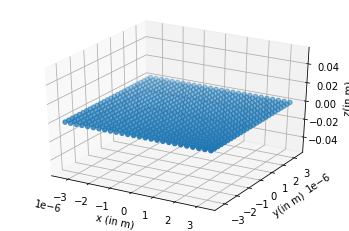

In [52]:
# define the wavelength, inter atomic distance
wavelength=500*10**-9 #m
a=0.53*wavelength
n_side=26          # numbe rof atoms in the side of a square array
n=n_side**2         #total number of atoms  
L=(n_side-1)*a      # total length of the square array  

#the storing positions of all atoms 
R1=np.zeros(shape=(n,3)) #(the jth element stores position of jth atom as (x_j,y_j,z_j) )

#initializing the positions of atoms as an array in X-Y plane, perpendicular to Z direction
for i in range(0,n):
    R1[i]=((-L/2+a*(i%n_side)),(L/2-a*int((i/n_side))),0)
#first atom at (-L/2,L/2) fill from left to right (upto (L/2,L/2)), then fill the next row starting from (-L/2,L/2-a) upto (L/2,L/2+a) 
#last atom is at (L/2,-L/2)

#wavenumber
#k= 2*np.pi/wavelength   

#initialise an instance of class atomic_array
arr1=atomic_array(a,R1)

#visualise the array
arr1.show_atomic_array()

#initialise an object of class gaussian ray with waist 0.3*root(n)*a 
ray1=gaussian_ray(0.3*np.sqrt(n)*a,wavelength)



## Plotting Transmissivity as a function of Disorder
We introduce gaussian error in the positions of the atoms, such that it dislocates them but within the plane.We find the transmissivty of the disordered array.
We repeat this for a particular standrad deviation of the gaussian 'for no_of_trials=30' no. of times and then take the average transmissivity obsreved in all these trials to be the average transmissivity associated with the standard deviation chosen. Then, we iterate this for different standard deviations, and plot average transmissivity vs standard deviation.

We can replace gaussian distribution of disorder with uniform distribution and standrad deviation with the range of the introduced disorder, using random.uniform()

In [ ]:
# define the wavelength, inter atomic distance
wavelength=500*10**-9 #m

#initial interatomic distance
a=0.2*wavelength

n_side=26          # numbe rof atoms in the side of a square array
n=n_side**2         #total number of atoms  
L=(n_side-1)*a      # total length of the square array  

#the storing positions of all atoms 
R1=np.zeros(shape=(n,3)) #(the jth element stores position of jth atom as (x_j,y_j,z_j) )

#initializing the positions of atoms as an array in X-Y plane, perpendicular to Z direction
for i in range(0,n):
    R1[i]=((-L/2+a*(i%n_side)),(L/2-a*int((i/n_side))),0)
#first atom at (-L/2,L/2) fill from left to right (upto (L/2,L/2)), then fill the next row starting from (-L/2,L/2-a) upto (L/2,L/2+a) 
#last atom is at (L/2,-L/2)

#wavenumber
k= 2*np.pi/wavelength   

#initialise an object of class gaussian ray with waist 0.3*root(n)*a 
ray1=gaussian_ray(0.3*np.sqrt(n)*a,wavelength)

#initialise an instance of class atomic_array
#arr1=atomic_array(a,R1)

stdev_of_disorder=np.linspace(0,arr1.a/2,20)
T_coeff=np.zeros(shape=len(stdev_of_disorder) )

for i in range(0,len(stdev_of_disorder)):
    #try  'no_of_trials' times with this limit   
    no_of_trials=30
    T_trials=np.zeros(shape=(no_of_trials))
    for l in range(0,no_of_trials):
       
        arr_iter=atomic_array(a,R1)
        #disorder in x   
        disorder=np.random.normal(loc=0,scale= stdev_of_disorder[i],size=(n,))
        arr_iter.R[:,0]=disorder+arr_iter.R[:,0]
       
        # for disorder in y
        disorder=np.random.normal(loc=0,scale=stdev_of_disorder[i],size=(n,))
        arr_iter.R[:,1]=disorder+arr_iter.R[:,1]
        
        #no disorder in z
        arr_iter.R[:,2]=arr_iter.R[:,2]
    
        T_trials[l]=arr_iter.T_R_coefficients(ray1,0,0,100*wavelength)[0]
        del arr_iter
    T_coeff[i]=np.mean(T_trials)  #take average of all these trials



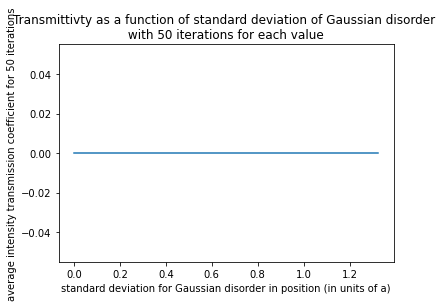

In [58]:
plt.plot(stdev_of_disorder/a, T_coeff)
plt.title(f'Transmittivty as a function of standard deviation of Gaussian disorder \n with {no_of_trials} iterations for each value ')
plt.xlabel('standard deviation for Gaussian disorder in position (in units of a)')
plt.ylabel(f'average intensity transmission coefficient for {no_of_trials} iterations')
plt.show()